## Code Modules

In [1]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-x45ren95
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-x45ren95
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.09266de4a8b3781c75947b25790e2191c32f70292_-py3-none-any.whl size=140357 sha256=2959fb538670e43e18a083f47a039bd77569d7dfe4a25b36c6919074f3c18382
  Stored in directory: /tmp/pip-ephem-wheel-cache-ilok85el/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,tensorflow as tf
import h5py,imageio,os
import seaborn as sn,pylab as pl
from keras.preprocessing import image as kimage
from tensorflow_docs.vis import embed
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True 
fpath='../input/child-and-adult-emotions/'

Using TensorFlow backend.


In [3]:
def path_to_tensor(img_path,fpath=fpath):
    img=kimage.load_img(fpath+img_path, 
                        target_size=(160,160))
    x=kimage.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths):
    tensor_list=[path_to_tensor(img_path) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)
def plcmap(cmap,n):
    return [pl.cm.get_cmap(cmap)(i/n)[:3] 
            for i in range(1,n+1)]
def animate(images):
    converted_images=np.clip(images*255,0,255)\
    .astype(np.uint8)
    imageio.mimsave('animation.gif',converted_images)
    return embed.embed_file('animation.gif')
def interpolate_hypersphere(v1,v2,steps):
    v1norm=tf.norm(v1)
    v2norm=tf.norm(v2)
    v2normalized=v2*(v1norm/v2norm)
    vectors=[]
    for step in range(steps):
        interpolated=v1+(v2normalized-v1)*step/(steps-1)
        interpolated_norm=tf.norm(interpolated)
        interpolated_normalized=\
        interpolated*(v1norm/interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)

## Data Processing

In [4]:
catlabels1=['adult','child']
catlabels2=['serious','sad','glad']
flist=sorted(os.listdir(fpath))
labels1=np.array([int(el[:2]) for el in flist],
               dtype='int32')-1
labels2=np.array([int(el[3:5]) for el in flist],
               dtype='int32')-1
images=np.array(paths_to_tensor(flist),
                dtype='float32')/255
N=labels1.shape[0]; n=int(.2*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images=images[shuffle_ids]
labels1,labels2=\
labels1[shuffle_ids],labels2[shuffle_ids]
x_test,x_train=images[:n],images[n:]
y_test1,y_train1=labels1[:n],labels1[n:]
y_test2,y_train2=labels2[:n],labels2[n:]

100%|██████████| 114/114 [00:00<00:00, 202.69it/s]


In [5]:
pd.DataFrame([[x_train.shape,x_test.shape],
              [x_train.dtype,x_test.dtype],
              [y_train1.shape,y_test1.shape],
              [y_train1.dtype,y_test1.dtype],
              [y_train2.shape,y_test2.shape],
              [y_train2.dtype,y_test2.dtype]],               
             columns=['train','test'])


train               test
0  (92, 160, 160, 3)  (22, 160, 160, 3)
1            float32            float32
2              (92,)              (22,)
3              int32              int32
4              (92,)              (22,)
5              int32              int32

In [6]:
with h5py.File('ChildAdultImages.h5','w') as f:
    f.create_dataset('train_images',data=x_train)
    f.create_dataset('train_labels1',data=y_train1)
    f.create_dataset('train_labels2',data=y_train2)
    f.create_dataset('test_images',data=x_test)
    f.create_dataset('test_labels1',data=y_test1)
    f.create_dataset('test_labels2',data=y_test2)
os.stat('ChildAdultImages.h5')

os.stat_result(st_mode=33188, st_ino=131083, st_dev=1793, st_nlink=1, st_uid=0, st_gid=0, st_size=35026944, st_atime=1598729119, st_mtime=1598729120, st_ctime=1598729120)

## Data Representation

In [7]:
set(labels1),set(labels2)

({0, 1}, {0, 1, 2})

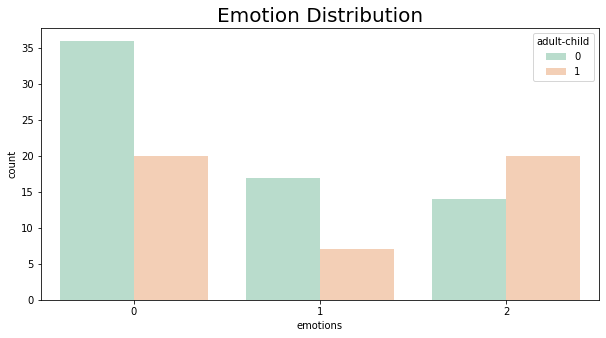

In [8]:
pl.figure(figsize=(10,5))
data=np.array([labels1,labels2]).T
data=pd.DataFrame(data,\
columns=['adult-child','emotions'])
sn.countplot(x='emotions',hue='adult-child',
             data=data,palette="Pastel2")
pl.title('Emotion Distribution',fontsize=20);

Label1:  0 adult
Label2:  0 serious


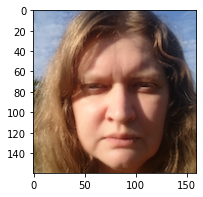

In [9]:
n=np.random.randint(10)
print('Label1: ',y_test1[n],catlabels1[y_test1[n]])
print('Label2: ',y_test2[n],catlabels2[y_test2[n]])
pl.figure(figsize=(3,3))
pl.imshow((x_test[n]));


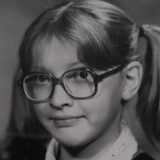

In [10]:
imgs=interpolate_hypersphere(x_test[1],x_test[2],180)
animate(imgs)